<a href="https://colab.research.google.com/github/FirasBellakhel/covid-detection-/blob/main/TEST_TICTACTRIP_a_rendre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
import csv
import numpy as np
from geopy.distance import distance
import matplotlib.pyplot as plt


from matplotlib.collections import LineCollection
import seaborn as sns
sns.set()

In [63]:
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/MyDrive/tictacex/cities.csv"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/tictacex/cities.csv


# Fonctions Utiles 

In [64]:
#calcule de distance en km du départ  a l'arrivé 
def distances(row):
    
    coords_1 = (row['o_latitude'], row['o_longitude'])
    coords_2 = (row['d_latitude'], row['d_longitude'])
    return distance(coords_1, coords_2).km

In [65]:
#Conversion heures décimale
# row : ligne du DataFrame  /col : colonne du DataFrame à convertir

def time(row, col):
    
   
    days = row[col].days
    seconds = row[col].seconds
    hours = days * 24 + seconds / 3600
    return hours

# Importation des donnes 

In [66]:
# Cities
df_cities = pd.read_csv('/content/drive/MyDrive/tictacex/cities.csv', index_col='id')
# Providers
df_providers = pd.read_csv('/content/drive/MyDrive/tictacex/providers.csv', index_col='id')
# Stations
df_stations = pd.read_csv('/content/drive/MyDrive/tictacex/stations.csv', index_col='id')
# Ticket_data
parse_dates = ['departure_ts', 'arrival_ts', 'search_ts'] # colonnes contenant des timestamps
df_ticket = pd.read_csv('/content/drive/MyDrive/tictacex/ticket_data.csv', index_col='id', parse_dates=parse_dates)

# netoyage des donnees pour ne pas fausser les resultats 

In [67]:
# Conversion des prix en euros
df_ticket['price'] = df_ticket['price_in_cents'] / 100

In [68]:
#détection des problémes liee a au fichier cities
df_cities.isnull().any()

local_name     False
unique_name     True
latitude       False
longitude      False
population      True
dtype: bool

In [69]:
df_ticket

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,price
id,,,,,,,,,,,,
6795025,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,542,45.5
6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,542,14.5
6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542,74.0
6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542,135.0
6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,542,77.1
...,...,...,...,...,...,...,...,...,...,...,...,...
6869182,13,279.0,10729.0,2017-10-27 02:30:00+00:00,2017-10-27 16:00:00+00:00,2590,2017-10-19 10:35:42.943000+00:00,"{408,408}",{8371},628,562,25.9
6869185,9,279.0,304.0,2017-10-27 07:00:00+00:00,2017-10-27 13:30:00+00:00,2700,2017-10-19 10:35:42.943000+00:00,"{1105,1105}",{9},628,562,27.0
6869187,8371,10642.0,304.0,2017-10-27 08:30:00+00:00,2017-10-27 15:15:00+00:00,3000,2017-10-19 10:35:42.943000+00:00,"{1105,1105}",{9},628,562,30.0


In [70]:
#remplacer les caracteres par un espace 
for columns in df_cities.columns:
    df_cities['local_name']=df_cities['local_name'].str.replace(r'\W',"")

<ipython-input-70-453f3e67312c>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cities['local_name']=df_cities['local_name'].str.replace(r'\W',"")


In [71]:
#localiser les colones ou il y a des donnes manquantes 
df_cities.isnull().sum()

local_name        0
unique_name       1
latitude          0
longitude         0
population     7671
dtype: int64

In [72]:
#colone population on compte la moyenne et on remplace les donnes manquantes par la moyenne mieux que les dropper 
df_cities["population"].mean()

336018.38753387536

In [73]:
df_cities = df_cities.fillna(df_cities["population"].mean())

In [74]:
#vérification 
df_cities.isnull().sum()

local_name     0
unique_name    0
latitude       0
longitude      0
population     0
dtype: int64

In [75]:
df_cities

,local_name,unique_name,latitude,longitude,population
id,,,,,
5159,PaduaVenetoItalia,padua,45.406435,11.876761,2.096780e+05
76,BarcelonaCataluñaEspaña,barcelona,41.385064,2.173404,1.611822e+06
81,BaselBaselStadtSchweiz,basel,47.593437,7.619812,3.360184e+05
259,ErlangenBayernDeutschland,erlangen,49.589674,11.011961,1.054120e+05
11979,BalșOltRomânia,balș,44.353354,24.095672,3.360184e+05
...,...,...,...,...,...
9964,SaintAndrélezLilleHautsdeFranceFrance,saint-andre-lez-lille,50.654250,3.047690,3.360184e+05
10863,KievШевченківськийрайонUkraine,kiev,50.450100,30.523400,3.360184e+05
11144,BrightonEnglandUK,brighton,50.822000,-0.137400,3.360184e+05


In [76]:
#noms en majuscules 

for columns in df_cities.columns:
    df_cities['local_name'] = df_cities['local_name'].str.upper() 
for columns in df_cities.columns:
    df_cities['unique_name'] = df_cities['unique_name'].str.upper()  

In [77]:
#remplacer les tiré par un espace 
for columns in df_cities.columns:
    df_cities['unique_name']=df_cities['unique_name'].replace(to_replace = '-' , value = '')
    


In [78]:
for columns in df_cities.columns:
    df_cities['unique_name']=df_cities['unique_name'].str.replace(r'\W',"")


<ipython-input-78-40da522faa8e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cities['unique_name']=df_cities['unique_name'].str.replace(r'\W',"")


In [79]:
#deux chiffres apres la virgules pour tout le monde 
df_cities['longitude']= round(df_cities['longitude'],2)
df_cities['latitude']= round(df_cities[ 'latitude'],2)
df_cities['population']= round(df_cities['population'],2)

In [80]:
#affichage pour une vérification final 
df_cities

,local_name,unique_name,latitude,longitude,population
id,,,,,
5159,PADUAVENETOITALIA,PADUA,45.41,11.88,209678.00
76,BARCELONACATALUÑAESPAÑA,BARCELONA,41.39,2.17,1611822.00
81,BASELBASELSTADTSCHWEIZ,BASEL,47.59,7.62,336018.39
259,ERLANGENBAYERNDEUTSCHLAND,ERLANGEN,49.59,11.01,105412.00
11979,BALȘOLTROMÂNIA,BALȘ,44.35,24.10,336018.39
...,...,...,...,...,...
9964,SAINTANDRÉLEZLILLEHAUTSDEFRANCEFRANCE,SAINTANDRELEZLILLE,50.65,3.05,336018.39
10863,KIEVШЕВЧЕНКІВСЬКИЙРАЙОНUKRAINE,KIEV,50.45,30.52,336018.39
11144,BRIGHTONENGLANDUK,BRIGHTON,50.82,-0.14,336018.39


In [81]:
#vérification pour le deuxiemme fichier df_providers
df_providers.isnull().sum()

company_id               0
provider_id             14
name                     0
fullname                 0
has_wifi                 3
has_plug                 3
has_adjustable_seats     3
has_bicycle              3
transport_type           0
dtype: int64

In [82]:
df_providers

,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
id,,,,,,,,,
9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
11,3,NaN,infobus,Infobus,False,False,False,False,bus
12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
13,5,NaN,flixbus,Flixbus,True,False,False,False,bus
...,...,...,...,...,...,...,...,...,...
8384,10,16,thalys,Thalys,True,True,False,True,train
8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
8387,30,NaN,vatry,Vatry,NaN,NaN,NaN,NaN,bus


In [83]:
df_providers['has_bicycle'].value_counts()

False    223
True       1
Name: has_bicycle, dtype: int64

In [84]:
df_providers['has_wifi'].value_counts()

False    220
True       4
Name: has_wifi, dtype: int64

In [85]:
df_providers['has_plug'].value_counts()

False    221
True       3
Name: has_plug, dtype: int64

In [86]:
df_providers['has_adjustable_seats'].value_counts()

False    212
True      12
Name: has_adjustable_seats, dtype: int64

In [87]:
df_providers['provider_id'] = pd.to_numeric(df_providers['provider_id'], errors='coerce')
df_providers.dropna(subset=['provider_id'], inplace=True)

df_providers['provider_id'] = df_providers['provider_id'].apply(lambda x: x if pd.notna(x) else np.random.randint(1, 9999999))
df_providers['provider_id'] = df_providers['provider_id'].astype(int)

In [88]:

df_providers['has_wifi'] = df_providers['has_wifi'].apply(lambda x: x if pd.notna(x) else np.random.choice([True, False]))

df_providers['has_plug'] = df_providers['has_plug'].apply(lambda x: x if pd.notna(x) else np.random.choice([True, False]))

df_providers['has_adjustable_seats'] = df_providers['has_adjustable_seats'].apply(lambda x: x if pd.notna(x) else np.random.choice([True, False]))

df_providers['has_bicycle'] = df_providers['has_bicycle'].apply(lambda x: x if pd.notna(x) else np.random.choice([True, False]))


In [89]:

new_id = {}

#Générer des ID uniques pour remplacer les ID répétés
for i, row in df_providers.iterrows():
    if row['company_id'] not in new_id:
        new_id[row['company_id']] = np.random.randint(1, 9999999)
    df_providers.at[i, 'company_id'] = new_id[row['company_id']]



In [90]:
df_providers_unique = df_providers.drop_duplicates(subset='company_id')

df_providers_duplicated = df_providers[df_providers.duplicated(subset='company_id', keep=False)]


In [91]:
df_providers

,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
id,,,,,,,,,
17,1800624,31,expressbusMunchen,Expressbus Munchen,False,False,False,False,bus
18,1800624,33,berlinLinienBus,Berlin Linien Bus,False,False,False,False,bus
19,1800624,37,ostfrieslandexpress,OstfrieslandExpress,False,False,False,False,bus
20,1800624,41,icBus,IC Bus,False,False,False,False,bus
21,1800624,45,busandfly,Busandfly,False,False,False,False,bus
...,...,...,...,...,...,...,...,...,...
8380,3664702,5,train,TER,False,False,True,False,train
8381,3664702,6,coraillunea,Intercités de Nuit,False,False,True,False,train
8382,3664702,8,eurostar,Eurostar,False,False,True,False,train


In [92]:
#vérification des donnes manquants 
df_providers.isnull().sum()

company_id              0
provider_id             0
name                    0
fullname                0
has_wifi                0
has_plug                0
has_adjustable_seats    0
has_bicycle             0
transport_type          0
dtype: int64

In [93]:
#ajustement et suppression des caracteres speciaux 

for columns in df_providers.columns:
    df_providers['fullname']=df_providers['fullname'].str.replace(r'\W',"")
for columns in df_providers.columns:
    df_providers['fullname'] = df_providers['fullname'].str.upper()   
for columns in df_providers.columns:
    df_providers['name'] = df_providers['name'].str.upper() 

<ipython-input-93-f27ce8516c9b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_providers['fullname']=df_providers['fullname'].str.replace(r'\W',"")


In [94]:
df_providers

,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
id,,,,,,,,,
17,1800624,31,EXPRESSBUSMUNCHEN,EXPRESSBUSMUNCHEN,False,False,False,False,bus
18,1800624,33,BERLINLINIENBUS,BERLINLINIENBUS,False,False,False,False,bus
19,1800624,37,OSTFRIESLANDEXPRESS,OSTFRIESLANDEXPRESS,False,False,False,False,bus
20,1800624,41,ICBUS,ICBUS,False,False,False,False,bus
21,1800624,45,BUSANDFLY,BUSANDFLY,False,False,False,False,bus
...,...,...,...,...,...,...,...,...,...
8380,3664702,5,TRAIN,TER,False,False,True,False,train
8381,3664702,6,CORAILLUNEA,INTERCITÉSDENUIT,False,False,True,False,train
8382,3664702,8,EUROSTAR,EUROSTAR,False,False,True,False,train


In [95]:
#verification des donnes manquants pour le 3eme fichier df_stations 
df_stations.isnull().sum()

unique_name    0
latitude       0
longitude      0
dtype: int64

In [96]:
df_stations['latitude']= round(df_stations[ 'latitude'],2)
df_stations['longitude']= round(df_stations['longitude'],2)

for columns in df_stations.columns:
     df_stations['unique_name'] = df_stations['unique_name'].str.upper()

In [97]:
df_ticket.isnull().sum()

company                0
o_station          41441
d_station          41441
departure_ts           0
arrival_ts             0
price_in_cents         0
search_ts              0
middle_stations    41441
other_companies    41441
o_city                 0
d_city                 0
price                  0
dtype: int64

In [98]:
df_ticket

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,price
id,,,,,,,,,,,,
6795025,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,542,45.5
6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,542,14.5
6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542,74.0
6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542,135.0
6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,542,77.1
...,...,...,...,...,...,...,...,...,...,...,...,...
6869182,13,279.0,10729.0,2017-10-27 02:30:00+00:00,2017-10-27 16:00:00+00:00,2590,2017-10-19 10:35:42.943000+00:00,"{408,408}",{8371},628,562,25.9
6869185,9,279.0,304.0,2017-10-27 07:00:00+00:00,2017-10-27 13:30:00+00:00,2700,2017-10-19 10:35:42.943000+00:00,"{1105,1105}",{9},628,562,27.0
6869187,8371,10642.0,304.0,2017-10-27 08:30:00+00:00,2017-10-27 15:15:00+00:00,3000,2017-10-19 10:35:42.943000+00:00,"{1105,1105}",{9},628,562,30.0


# Calcule 

In [99]:
# Calcul des durées de trajet et conversion en heure
df_ticket['travel_time'] = df_ticket.arrival_ts - df_ticket.departure_ts
df_ticket['travel_time_hours'] = df_ticket.apply(time, args=['travel_time'], axis=1)

In [100]:
# Merge des informations sur les coordonnées dans le DataFrame df_ticket
df_ticket = pd.merge(df_ticket, df_cities[['latitude', 'longitude']], how='left', left_on=['o_city'], right_on=['id'])
df_ticket.rename(columns={'latitude': 'o_latitude', 'longitude': 'o_longitude'}, inplace=True)
df_ticket = pd.merge(df_ticket, df_cities[['latitude', 'longitude']], how='left', left_on=['d_city'], right_on=['id'])
df_ticket.rename(columns={'latitude': 'd_latitude', 'longitude': 'd_longitude'}, inplace=True)

In [101]:
# Calcul des distances de trajet
df_ticket['distance'] = df_ticket.apply(distances, axis=1)

In [102]:
df_ticket

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,price,travel_time,travel_time_hours,o_latitude,o_longitude,d_latitude,d_longitude,distance
0,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,542,45.5,0 days 06:10:00,6.166667,47.91,1.91,43.60,3.92,503.873273
1,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,542,14.5,0 days 17:50:00,17.833333,47.91,1.91,43.60,3.92,503.873273
2,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542,74.0,1 days 07:57:00,31.950000,47.91,1.91,43.60,3.92,503.873273
3,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542,135.0,0 days 21:35:00,21.583333,47.91,1.91,43.60,3.92,503.873273
4,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,542,77.1,0 days 21:46:00,21.766667,47.91,1.91,43.60,3.92,503.873273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,13,279.0,10729.0,2017-10-27 02:30:00+00:00,2017-10-27 16:00:00+00:00,2590,2017-10-19 10:35:42.943000+00:00,"{408,408}",{8371},628,562,25.9,0 days 13:30:00,13.500000,48.85,2.35,47.25,-1.52,338.898000
74164,9,279.0,304.0,2017-10-27 07:00:00+00:00,2017-10-27 13:30:00+00:00,2700,2017-10-19 10:35:42.943000+00:00,"{1105,1105}",{9},628,562,27.0,0 days 06:30:00,6.500000,48.85,2.35,47.25,-1.52,338.898000
74165,8371,10642.0,304.0,2017-10-27 08:30:00+00:00,2017-10-27 15:15:00+00:00,3000,2017-10-19 10:35:42.943000+00:00,"{1105,1105}",{9},628,562,30.0,0 days 06:45:00,6.750000,48.85,2.35,47.25,-1.52,338.898000
74166,13,279.0,304.0,2017-10-27 13:25:00+00:00,2017-10-27 21:10:00+00:00,2880,2017-10-19 10:35:42.943000+00:00,"{863,863}",{13},628,562,28.8,0 days 07:45:00,7.750000,48.85,2.35,47.25,-1.52,338.898000


In [103]:
# Merge des providers dans le DataFrame df_ticket
df_ticket = pd.merge(df_ticket, df_providers[['fullname', 'transport_type']], how='left', left_on=['company'], right_on=['id'])


In [104]:
print(df_ticket.transport_type.unique())

[nan 'train' 'bus']


In [105]:
df_ticket.isnull().sum()

company                  0
o_station            41441
d_station            41441
departure_ts             0
arrival_ts               0
price_in_cents           0
search_ts                0
middle_stations      41441
other_companies      41441
o_city                   0
d_city                   0
price                    0
travel_time              0
travel_time_hours        0
o_latitude               0
o_longitude              0
d_latitude               0
d_longitude              0
distance                 0
fullname             54796
transport_type       54796
dtype: int64

In [106]:
 df_ticket

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,...,price,travel_time,travel_time_hours,o_latitude,o_longitude,d_latitude,d_longitude,distance,fullname,transport_type
0,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,...,45.5,0 days 06:10:00,6.166667,47.91,1.91,43.60,3.92,503.873273,NaN,NaN
1,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,...,14.5,0 days 17:50:00,17.833333,47.91,1.91,43.60,3.92,503.873273,NaN,NaN
2,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,74.0,1 days 07:57:00,31.950000,47.91,1.91,43.60,3.92,503.873273,INTERCITÉS,train
3,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,135.0,0 days 21:35:00,21.583333,47.91,1.91,43.60,3.92,503.873273,INTERCITÉS,train
4,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,...,77.1,0 days 21:46:00,21.766667,47.91,1.91,43.60,3.92,503.873273,INTERCITÉSDENUIT,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,13,279.0,10729.0,2017-10-27 02:30:00+00:00,2017-10-27 16:00:00+00:00,2590,2017-10-19 10:35:42.943000+00:00,"{408,408}",{8371},628,...,25.9,0 days 13:30:00,13.500000,48.85,2.35,47.25,-1.52,338.898000,NaN,NaN
74164,9,279.0,304.0,2017-10-27 07:00:00+00:00,2017-10-27 13:30:00+00:00,2700,2017-10-19 10:35:42.943000+00:00,"{1105,1105}",{9},628,...,27.0,0 days 06:30:00,6.500000,48.85,2.35,47.25,-1.52,338.898000,NaN,NaN
74165,8371,10642.0,304.0,2017-10-27 08:30:00+00:00,2017-10-27 15:15:00+00:00,3000,2017-10-19 10:35:42.943000+00:00,"{1105,1105}",{9},628,...,30.0,0 days 06:45:00,6.750000,48.85,2.35,47.25,-1.52,338.898000,NaN,NaN
74166,13,279.0,304.0,2017-10-27 13:25:00+00:00,2017-10-27 21:10:00+00:00,2880,2017-10-19 10:35:42.943000+00:00,"{863,863}",{13},628,...,28.8,0 days 07:45:00,7.750000,48.85,2.35,47.25,-1.52,338.898000,NaN,NaN


In [107]:
# Jointure sur l'id des villes pour récupérer les prix
trip_prices = pd.merge(df_ticket[['o_city', 'd_city', 'price']], df_cities[['unique_name']], how='left', left_on='o_city', right_on=['id'])
trip_prices.rename(columns={'unique_name': 'o_name'}, inplace=True)
trip_prices = pd.merge(trip_prices, df_cities[['unique_name']], how='left', left_on='d_city', right_on=['id'])
trip_prices.rename(columns={'unique_name': 'd_name'}, inplace=True)

# Calcul des statistiques de prix par trajet
trip_prices = trip_prices.groupby(['o_name', 'd_name']).agg({'price': ['count', 'min', 'max', 'mean']})

trip_prices

price                          
                                      count    min    max        mean
o_name              d_name                                           
AEROPORTPARISVATRY  TROYES                1   53.0   53.0   53.000000
AGDE                AMSTERDAM             5  186.0  220.0  203.200000
AGEN                DIJON                 2   98.6  136.5  117.550000
                    MARSEILLE            30   20.0   89.2   40.426667
                    MARSEILLEAEROPORT     6   37.0   40.5   38.333333
...                                     ...    ...    ...         ...
VILLEFRANCHESURCHER BORDEAUX             10   30.6   76.7   58.850000
VITRE               NICE                  2  150.7  219.2  184.950000
ZURICH              DIJON                 4   14.0   24.0   18.725000
                    LIEGE                 9   40.5   41.9   40.966667
                    STRASBOURG            5   14.0   17.8   15.900000

[1437 rows x 4 columns]

In [108]:
# Choix des villes
ville1 = 'PARIS'
ville2 = 'MARSEILLE'

print("statistiques sur les prix du trajet {} - {} :".format(ville1, ville2))
print(trip_prices.loc[ville1, ville2])

statistiques sur les prix du trajet PARIS - MARSEILLE :
price  count    898.000000
       min       20.000000
       max      204.000000
       mean      83.800445
Name: (PARIS, MARSEILLE), dtype: float64


In [109]:
df_ticket=df_ticket.dropna()

In [110]:
df_ticket

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,...,price,travel_time,travel_time_hours,o_latitude,o_longitude,d_latitude,d_longitude,distance,fullname,transport_type
2,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,74.0,1 days 07:57:00,31.950000,47.91,1.91,43.60,3.92,503.873273,INTERCITÉS,train
3,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,135.0,0 days 21:35:00,21.583333,47.91,1.91,43.60,3.92,503.873273,INTERCITÉS,train
4,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,...,77.1,0 days 21:46:00,21.766667,47.91,1.91,43.60,3.92,503.873273,INTERCITÉSDENUIT,train
60,8377,1898.0,396.0,2017-10-06 06:04:00+00:00,2017-10-06 08:58:00+00:00,3220,2017-10-01 01:04:35.340000+00:00,"{406,406}",{8380},628,...,32.2,0 days 02:54:00,2.900000,48.85,2.35,50.64,3.08,205.923208,INTERCITÉS,train
61,8376,1898.0,396.0,2017-10-06 12:52:00+00:00,2017-10-06 14:21:00+00:00,2850,2017-10-01 01:04:35.342000+00:00,"{10865,10865}",{8376},628,...,28.5,0 days 01:29:00,1.483333,48.85,2.35,50.64,3.08,205.923208,TGV,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74151,8376,6799.0,6591.0,2017-10-27 19:40:00+00:00,2017-10-28 08:30:00+00:00,8450,2017-10-19 10:35:40.168000+00:00,"{3748,3748}",{8380},628,...,84.5,0 days 12:50:00,12.833333,48.85,2.35,47.25,-1.52,338.898000,TGV,train
74152,8376,6799.0,6591.0,2017-10-27 10:40:00+00:00,2017-10-27 14:50:00+00:00,7850,2017-10-19 10:35:40.168000+00:00,"{408,408}",{8376},628,...,78.5,0 days 04:10:00,4.166667,48.85,2.35,47.25,-1.52,338.898000,TGV,train
74153,8376,767.0,6591.0,2017-10-27 16:38:00+00:00,2017-10-27 18:54:00+00:00,8400,2017-10-19 10:35:40.168000+00:00,"{583,583}",{8376},628,...,84.0,0 days 02:16:00,2.266667,48.85,2.35,47.25,-1.52,338.898000,TGV,train
74154,8376,6799.0,6591.0,2017-10-27 14:14:00+00:00,2017-10-27 17:16:00+00:00,7620,2017-10-19 10:35:40.168000+00:00,"{583,583}",{8380},628,...,76.2,0 days 03:02:00,3.033333,48.85,2.35,47.25,-1.52,338.898000,TGV,train


In [111]:
# Jointure sur l'id des villes pour récupérer les temps de trajet
trip_durations = pd.merge(df_ticket[['o_city', 'd_city', 'travel_time', 'travel_time_hours']], df_cities[['unique_name']], how='left', left_on='o_city', right_on=['id'])
trip_durations.rename(columns={'unique_name': 'o_name'}, inplace=True)
trip_durations = pd.merge(trip_durations, df_cities[['unique_name']], how='left', left_on='d_city', right_on=['id'])
trip_durations.rename(columns={'unique_name': 'd_name'}, inplace=True)

# Calcul des statistiques de prix par trajet
trip_durations = trip_durations.groupby(['o_name', 'd_name']).agg({'travel_time': ['min', 'max', pd.Series.mean]})

trip_durations

travel_time                  \
                                                min             max   
o_name              d_name                                            
AGDE                AMSTERDAM       0 days 08:53:00 0 days 15:54:00   
AGEN                DIJON           0 days 12:24:00 0 days 15:01:00   
                    MARSEILLE       0 days 05:36:00 0 days 08:16:00   
                    TOULOUSE        0 days 04:11:00 0 days 04:11:00   
AIXENPROVENCE       CLERMONTFERRAND 0 days 04:06:00 0 days 21:59:00   
...                                             ...             ...   
VESOUL              PARIS           0 days 03:14:00 0 days 16:26:00   
VIERZON             BORDEAUX        0 days 04:22:00 1 days 00:40:00   
                    PARIS           0 days 02:27:00 1 days 02:28:00   
VILLEFRANCHESURCHER BORDEAUX        0 days 03:10:00 1 days 13:44:00   
VITRE               NICE            0 days 09:53:00 0 days 11:05:00   

                                                               
                                                         mean  
o_name              d_name                                     
AGDE                AMSTERDAM                 0 days 10:18:48  
AGEN                DIJON                     0 days 13:42:30  
                    MARSEILLE                 0 days 06:46:12  
                    TOULOUSE                  0 days 04:11:00  
AIXENPROVENCE       CLERMONTFERRAND    0 days 10:20:56.250000  
...                                                       ...  
VESOUL              PARIS                     0 days 07:10:00  
VIERZON             BORDEAUX                  0 days 09:52:30  
                    PARIS           0 days 07:35:01.935483870  
VILLEFRANCHESURCHER BORDEAUX                  0 days 11:40:30  
VITRE               NICE                      0 days 10:29:00  

[719 rows x 3 columns]

In [112]:
# Choix des villes
ville1 = 'PARIS'
ville2 = 'MARSEILLE'

print("statistiques sur les temps de trajet {} - {} :".format(ville1, ville2))
print(trip_durations.loc[ville1, ville2])

statistiques sur les temps de trajet PARIS - MARSEILLE :
travel_time  min              0 days 03:25:00
             max              1 days 06:00:00
             mean   0 days 06:17:30.424242424
Name: (PARIS, MARSEILLE), dtype: timedelta64[ns]


In [113]:
# classification 0-200km, 201-800km, 800-2000km, 2000+km
df_ticket.loc[df_ticket.distance <= 200, 'dist_class'] = '[0, 200]'
df_ticket.loc[(df_ticket.distance > 200) & (df_ticket.distance <= 800), 'dist_class'] = '[201, 800]'
df_ticket.loc[(df_ticket.distance > 800) & (df_ticket.distance <= 2000), 'dist_class'] = '[801, 2000]'
df_ticket.loc[df_ticket.distance > 2000, 'dist_class'] = '[2001 +)'

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [114]:
stat_df = df_ticket.groupby(['dist_class', 'transport_type']).agg({'travel_time': ['min', 'max', pd.Series.mean], 'price' : ['min', 'max', 'mean']})
stat_df

travel_time                  \
                                       min             max   
dist_class  transport_type                                   
[0, 200]    bus            0 days 01:05:00 1 days 02:12:00   
            train          0 days 00:39:00 1 days 10:27:00   
[201, 800]  bus            0 days 02:29:00 1 days 10:13:00   
            train          0 days 01:08:00 2 days 00:27:00   
[801, 2000] bus            0 days 19:45:00 2 days 03:45:00   
            train          0 days 03:33:00 1 days 16:37:00   

                                                      price          \
                                                mean    min     max   
dist_class  transport_type                                            
[0, 200]    bus            0 days 03:45:07.128712871   9.90   78.00   
            train          0 days 04:25:09.840098400   4.90  251.00   
[201, 800]  bus            0 days 11:30:48.768472906  15.16  224.80   
            train          0 days 07:40:39.543514566  14.00  385.50   
[801, 2000] bus            1 days 03:49:12.631578947  38.57  163.95   
            train          0 days 12:09:31.021671826  19.40  375.50   

                                        
                                  mean  
dist_class  transport_type              
[0, 200]    bus              24.750297  
            train            34.879008  
[201, 800]  bus              62.623892  
            train            91.247795  
[801, 2000] bus              70.988158  
            train           154.637461

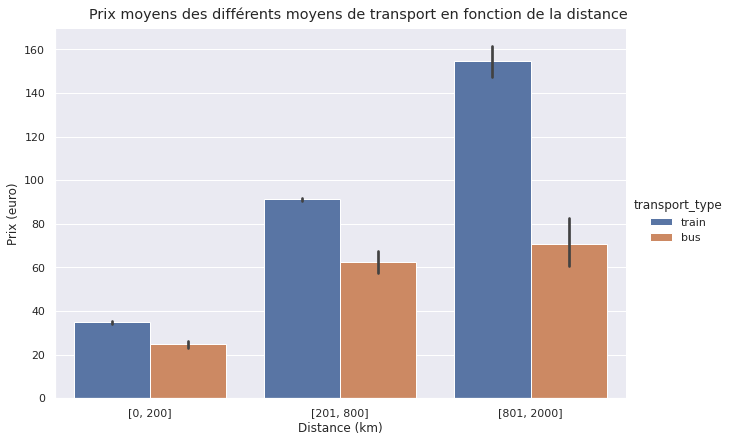

In [115]:
order = ['[0, 200]', '[201, 800]', '[801, 2000]']
g = sns.catplot(x="dist_class", y="price", hue="transport_type", kind="bar", data=df_ticket, height=6, aspect=1.5, order=order)
g.fig.suptitle('Prix moyens des différents moyens de transport en fonction de la distance', x=0.5, y=1.02)
plt.xlabel('Distance (km)')
plt.ylabel('Prix (euro)');

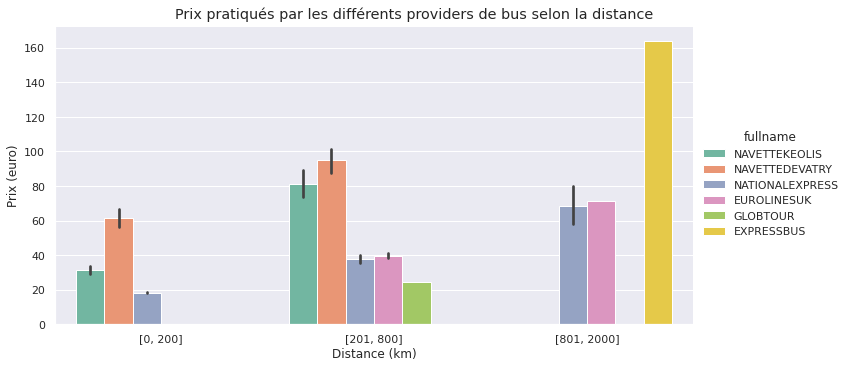

In [116]:
# Bus
g = sns.catplot(x="dist_class", y="price", hue="fullname", kind="bar", data=df_ticket[df_ticket.transport_type == 'bus'], palette="Set2", aspect=2, order=order)
g.fig.suptitle('Prix pratiqués par les différents providers de bus selon la distance', x=0.5, y=1.02)
plt.xlabel('Distance (km)')
plt.ylabel('Prix (euro)');

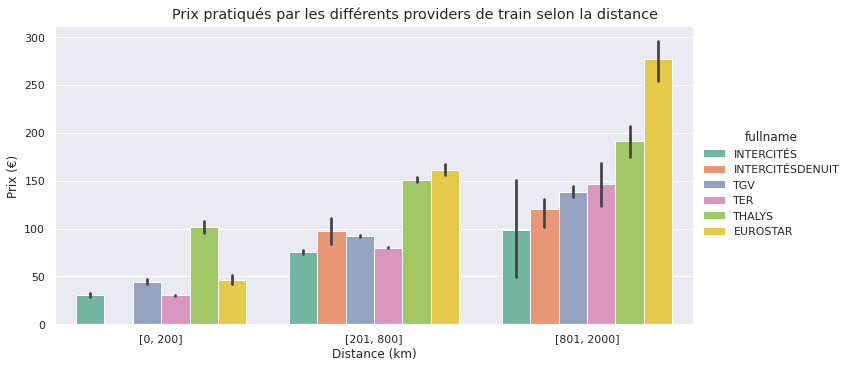

In [117]:
# Train
g = sns.catplot(x="dist_class", y="price", hue="fullname", kind="bar", data=df_ticket[df_ticket.transport_type == 'train'], palette="Set2", aspect=2, order=order)
g.fig.suptitle('Prix pratiqués par les différents providers de train selon la distance', x=0.5, y=1.02)
plt.xlabel('Distance (km)')
plt.ylabel('Prix (€)');

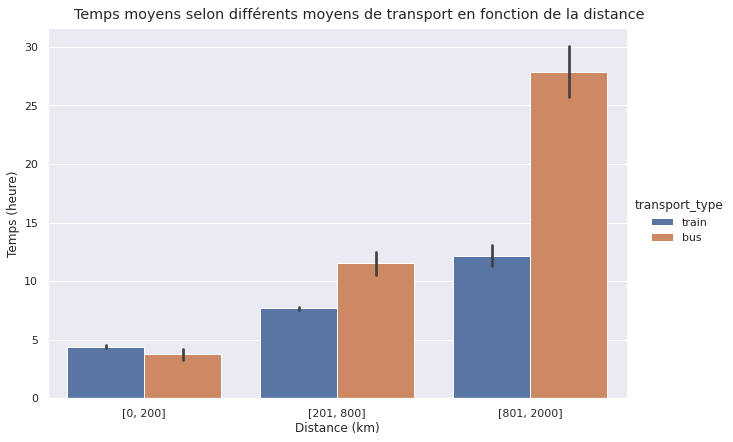

In [118]:
g2 = sns.catplot(x="dist_class", y="travel_time_hours", hue="transport_type", kind="bar", data=df_ticket, height=6, aspect=1.5, order=order);
g2.fig.suptitle('Temps moyens selon différents moyens de transport en fonction de la distance', x=0.5, y=1.02)
plt.xlabel('Distance (km)')
plt.ylabel('Temps (heure)');

# algorithme de prédiction des prix

In [120]:
from lightgbm import LGBMRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import LinearSVR

In [121]:
df_ticket

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,...,travel_time,travel_time_hours,o_latitude,o_longitude,d_latitude,d_longitude,distance,fullname,transport_type,dist_class
2,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,1 days 07:57:00,31.950000,47.91,1.91,43.60,3.92,503.873273,INTERCITÉS,train,"[201, 800]"
3,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,0 days 21:35:00,21.583333,47.91,1.91,43.60,3.92,503.873273,INTERCITÉS,train,"[201, 800]"
4,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,...,0 days 21:46:00,21.766667,47.91,1.91,43.60,3.92,503.873273,INTERCITÉSDENUIT,train,"[201, 800]"
60,8377,1898.0,396.0,2017-10-06 06:04:00+00:00,2017-10-06 08:58:00+00:00,3220,2017-10-01 01:04:35.340000+00:00,"{406,406}",{8380},628,...,0 days 02:54:00,2.900000,48.85,2.35,50.64,3.08,205.923208,INTERCITÉS,train,"[201, 800]"
61,8376,1898.0,396.0,2017-10-06 12:52:00+00:00,2017-10-06 14:21:00+00:00,2850,2017-10-01 01:04:35.342000+00:00,"{10865,10865}",{8376},628,...,0 days 01:29:00,1.483333,48.85,2.35,50.64,3.08,205.923208,TGV,train,"[201, 800]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74151,8376,6799.0,6591.0,2017-10-27 19:40:00+00:00,2017-10-28 08:30:00+00:00,8450,2017-10-19 10:35:40.168000+00:00,"{3748,3748}",{8380},628,...,0 days 12:50:00,12.833333,48.85,2.35,47.25,-1.52,338.898000,TGV,train,"[201, 800]"
74152,8376,6799.0,6591.0,2017-10-27 10:40:00+00:00,2017-10-27 14:50:00+00:00,7850,2017-10-19 10:35:40.168000+00:00,"{408,408}",{8376},628,...,0 days 04:10:00,4.166667,48.85,2.35,47.25,-1.52,338.898000,TGV,train,"[201, 800]"
74153,8376,767.0,6591.0,2017-10-27 16:38:00+00:00,2017-10-27 18:54:00+00:00,8400,2017-10-19 10:35:40.168000+00:00,"{583,583}",{8376},628,...,0 days 02:16:00,2.266667,48.85,2.35,47.25,-1.52,338.898000,TGV,train,"[201, 800]"
74154,8376,6799.0,6591.0,2017-10-27 14:14:00+00:00,2017-10-27 17:16:00+00:00,7620,2017-10-19 10:35:40.168000+00:00,"{583,583}",{8380},628,...,0 days 03:02:00,3.033333,48.85,2.35,47.25,-1.52,338.898000,TGV,train,"[201, 800]"


In [122]:
print(df_ticket.shape)
df_ticket.head()

(19372, 22)


,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,...,travel_time,travel_time_hours,o_latitude,o_longitude,d_latitude,d_longitude,distance,fullname,transport_type,dist_class
2,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,1 days 07:57:00,31.950000,47.91,1.91,43.60,3.92,503.873273,INTERCITÉS,train,"[201, 800]"
3,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,0 days 21:35:00,21.583333,47.91,1.91,43.60,3.92,503.873273,INTERCITÉS,train,"[201, 800]"
4,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,...,0 days 21:46:00,21.766667,47.91,1.91,43.60,3.92,503.873273,INTERCITÉSDENUIT,train,"[201, 800]"
60,8377,1898.0,396.0,2017-10-06 06:04:00+00:00,2017-10-06 08:58:00+00:00,3220,2017-10-01 01:04:35.340000+00:00,"{406,406}",{8380},628,...,0 days 02:54:00,2.900000,48.85,2.35,50.64,3.08,205.923208,INTERCITÉS,train,"[201, 800]"
61,8376,1898.0,396.0,2017-10-06 12:52:00+00:00,2017-10-06 14:21:00+00:00,2850,2017-10-01 01:04:35.342000+00:00,"{10865,10865}",{8376},628,...,0 days 01:29:00,1.483333,48.85,2.35,50.64,3.08,205.923208,TGV,train,"[201, 800]"


In [127]:
# Calcul du temps restant entre la recherche et le départ
df_ticket['time_before_departure'] = df_ticket.departure_ts - df_ticket.search_ts
df_ticket['time_before_departure_hours'] = df_ticket.apply(time, args=['time_before_departure'], axis=1)

<ipython-input-127-1773becdccd3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['time_before_departure'] = df_ticket.departure_ts - df_ticket.search_ts
<ipython-input-127-1773becdccd3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['time_before_departure_hours'] = df_ticket.apply(time, args=['time_before_departure'], axis=1)


In [128]:
def n_middle_stations(row):
    """Fonction de relevé du nombre de correspondance dans un trajet"""
    if pd.isna(row.middle_stations):
        return 0
    else:
        return row.middle_stations.count(',') + 1

df_ticket['n_middle_stations'] = df_ticket.apply(n_middle_stations, axis=1)

<ipython-input-128-6bc1a2c97c88>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['n_middle_stations'] = df_ticket.apply(n_middle_stations, axis=1)


In [129]:

df_ticket['month'] = pd.DatetimeIndex(df_ticket['departure_ts']).month

<ipython-input-129-c1672023c26c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['month'] = pd.DatetimeIndex(df_ticket['departure_ts']).month


In [130]:
df_ticket['n_other_companies'] = df_ticket['other_companies'].str.split(',').str.len().fillna(0)

<ipython-input-130-47de4ceb7797>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['n_other_companies'] = df_ticket['other_companies'].str.split(',').str.len().fillna(0)


In [131]:
df_ticket

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,...,d_longitude,distance,fullname,transport_type,dist_class,time_before_departure,time_before_departure_hours,n_middle_stations,month,n_other_companies
2,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,3.92,503.873273,INTERCITÉS,train,"[201, 800]",12 days 13:13:19.788000,301.221944,4,10,2
3,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,3.92,503.873273,INTERCITÉS,train,"[201, 800]",12 days 13:13:19.787000,301.221944,4,10,2
4,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,...,3.92,503.873273,INTERCITÉSDENUIT,train,"[201, 800]",12 days 21:32:19.787000,309.538611,2,10,1
60,8377,1898.0,396.0,2017-10-06 06:04:00+00:00,2017-10-06 08:58:00+00:00,3220,2017-10-01 01:04:35.340000+00:00,"{406,406}",{8380},628,...,3.08,205.923208,INTERCITÉS,train,"[201, 800]",5 days 04:59:24.660000,124.990000,2,10,1
61,8376,1898.0,396.0,2017-10-06 12:52:00+00:00,2017-10-06 14:21:00+00:00,2850,2017-10-01 01:04:35.342000+00:00,"{10865,10865}",{8376},628,...,3.08,205.923208,TGV,train,"[201, 800]",5 days 11:47:24.658000,131.790000,2,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74151,8376,6799.0,6591.0,2017-10-27 19:40:00+00:00,2017-10-28 08:30:00+00:00,8450,2017-10-19 10:35:40.168000+00:00,"{3748,3748}",{8380},628,...,-1.52,338.898000,TGV,train,"[201, 800]",8 days 09:04:19.832000,201.071944,2,10,1
74152,8376,6799.0,6591.0,2017-10-27 10:40:00+00:00,2017-10-27 14:50:00+00:00,7850,2017-10-19 10:35:40.168000+00:00,"{408,408}",{8376},628,...,-1.52,338.898000,TGV,train,"[201, 800]",8 days 00:04:19.832000,192.071944,2,10,1
74153,8376,767.0,6591.0,2017-10-27 16:38:00+00:00,2017-10-27 18:54:00+00:00,8400,2017-10-19 10:35:40.168000+00:00,"{583,583}",{8376},628,...,-1.52,338.898000,TGV,train,"[201, 800]",8 days 06:02:19.832000,198.038611,2,10,1
74154,8376,6799.0,6591.0,2017-10-27 14:14:00+00:00,2017-10-27 17:16:00+00:00,7620,2017-10-19 10:35:40.168000+00:00,"{583,583}",{8380},628,...,-1.52,338.898000,TGV,train,"[201, 800]",8 days 03:38:19.832000,195.638611,2,10,1


In [134]:
df_ticket.shape

(19372, 27)

In [136]:
features = ['company', 'travel_time_hours', 'distance', 'transport_type', 'time_before_departure_hours', 'n_middle_stations', 'month', 'n_other_companies']
X = df_ticket[features]
y = df_ticket.price.values

In [139]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
categorical_columns = ['company', 'transport_type', 'month']
numerical_columns = ['travel_time_hours', 'distance', 'time_before_departure_hours', 'n_middle_stations']
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(categories='auto'), categorical_columns)],
    remainder='passthrough')

X = preprocessor.fit_transform(X)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [147]:
import xgboost as xgb

rf = xgb.XGBRegressor(n_estimators=1000,
                       max_depth=3, 
                       learning_rate=0.1, 
                       subsample=1, 
                       colsample_bytree=1, 
                       min_child_weight=1,
                       objective='reg:squarederror',
                       n_jobs=-1)

rf.fit(X_train, y_train)


XGBRegressor(n_estimators=1000, n_jobs=-1, objective='reg:squarederror')

In [148]:
#On effectue les prédictions sur le jeu de test 


y_pred = rf.predict(X_test)


Text(0.5, 1.0, 'Distribution des résidus de prédiction')

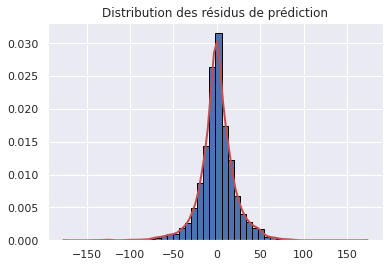

In [157]:
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error


residuals = y_pred - y_test
density = gaussian_kde(residuals)
x = np.linspace(min(residuals), max(residuals), 100)
plt.hist(residuals, bins=50, density=True, edgecolor='black')
plt.plot(x, density(x), 'r', linewidth=2)
plt.title('Distribution des résidus de prédiction')


In [158]:
print("RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))
print("MAE = {}".format(mean_absolute_error(y_test, y_pred)))

RMSE = 21.157172489031225
MAE = 14.361608630933963


In [159]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [161]:
#on essai random forest 

rf = RandomForestRegressor(n_estimators=1000, 
                             criterion='mse',
                             max_depth=None,
                             min_impurity_decrease=0.0001)

rf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


RandomForestRegressor(criterion='mse', min_impurity_decrease=0.0001,
                      n_estimators=1000)

In [162]:
y_pred = rf.predict(X_test)

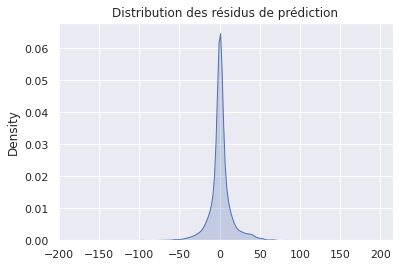

In [163]:
sns.kdeplot(y_pred - y_test, shade=True, gridsize=200)
plt.title('Distribution des résidus de prédiction');

In [164]:
print("RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))
print("MAE = {}".format(mean_absolute_error(y_test, y_pred)))

RMSE = 15.748661572274408
MAE = 8.72902604064566


In [ ]:
#La performance du modèle est indiquée par la valeur de l'erreur RMSE qui est d'environ 15 € et l'erreur MAE d'environ 8 €, ces valeurs semblent bonnes en première analyse. Pour optimiser davantage les résultats obtenus, il serait judicieux de mettre en place une validation croisée pour identifier les meilleurs paramètres d'hyper-paramétrage ou de tester d'autres approches d'algorithmes.